In [94]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch import nn
from torch.optim import Adam, SGD
from tqdm import tqdm

import re
#from pymorphy2 import MorphAnalyzer
#from stop_words import get_stop_words

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Формирование обучающего множества

In [2]:
FILE_PATH = './datasets/lenta-ru-news.csv' # путь к данным для обучения
MODEL_PATH = './models' # директория для сохранения моделей

Для обучения будущей модели определять темы новостей возьмем dataset, состоящий из новостный статей ресурса Lenta.Ru <br>
 https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz 

In [25]:
df_lenta_articles = pd.read_csv(FILE_PATH)

In [26]:
df_lenta_articles.head(3)

,url,title,text,topic,tags
0,https://lenta.ru/news/2018/12/14/cancer/,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия,Общество
1,https://lenta.ru/news/2018/12/15/doping/,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт,Зимние виды
2,https://lenta.ru/news/2018/12/15/disneyland/,Обнаружено самое счастливое место на планете,Сотрудники социальной сети Instagram проанализ...,Путешествия,Мир


In [27]:
df_lenta_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739351 entries, 0 to 739350
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     739351 non-null  object
 1   title   739351 non-null  object
 2   text    739346 non-null  object
 3   topic   739148 non-null  object
 4   tags    712837 non-null  object
dtypes: object(5)
memory usage: 28.2+ MB


In [28]:
# Проверка на повторяющиеся строки
df_lenta_articles.duplicated().sum()

175

In [29]:
df_lenta_articles[df_lenta_articles.duplicated(keep=False)].head(5)

,url,title,text,topic,tags
630193,https://lenta.ru/news/2004/12/22/blast/,"В Ираке взорван автомобиль, есть многочисленны...",В среду в иракском городе Эль-Махмудия (Mahmud...,Мир,Все
630296,https://lenta.ru/news/2004/12/21/killed/,В Грозном убит боевик из отряда Басаева,В Ленинском районе Грозного сотрудники чеченск...,Россия,Все
630387,https://lenta.ru/news/2004/12/22/blast/,"В Ираке взорван автомобиль, есть многочисленны...",В среду в иракском городе Эль-Махмудия (Mahmud...,Мир,Все
630406,https://lenta.ru/news/2004/12/21/killed/,В Грозном убит боевик из отряда Басаева,В Ленинском районе Грозного сотрудники чеченск...,Россия,Все
632401,https://lenta.ru/news/2004/11/24/house/,Сторонники Ющенко захватили одно из зданий адм...,Сторонники кандидата в президенты Украины от о...,Мир,Все


In [30]:
# исключение повторяющих строк
df_lenta_articles = df_lenta_articles.drop_duplicates()

In [31]:
df_lenta_articles.duplicated().sum()

0

In [32]:
print(df_lenta_articles['topic'].unique()) #темы статей

['Россия' 'Спорт' 'Путешествия' 'Мир' 'Бывший СССР' 'Интернет и СМИ'
 'Силовые структуры' 'Экономика' 'Культура' 'Дом' 'Наука и техника'
 'Из жизни' 'Ценности' 'Бизнес' '69-я параллель' nan 'Культпросвет '
 'Крым' 'Оружие' 'Легпром' 'МедНовости' 'Библиотека' 'ЧМ-2014' 'Сочи']


In [33]:
# Оставим только "интересные" темы 
main_topics = ['Силовые структуры', 'Экономика', 'Культура', 'Спорт',
               'Наука и техника', 'МедНовости']

In [34]:
# Помимо тем, есть еще классификация по тегам, поэтому выберем несколько интересных тегов
print(df_lenta_articles['tags'].unique())

['Общество' 'Зимние виды' 'Мир' 'Политика' 'Украина' 'Coцсети'
 'Следствие и суд' 'Хоккей' 'Деньги' 'Госэкономика' 'Происшествия'
 'Футбол' 'Бизнес' 'Музыка' 'Квартира' 'Бокс и ММА' 'Театр' 'Оружие'
 'Дача' 'Прибалтика' 'Рынки' 'Звери' 'Техника' 'Интернет' 'Люди' 'Наука'
 'Внешний вид' 'Кино' 'ТВ и радио' 'Регионы' 'Космос' 'Явления' 'Стиль'
 'Белоруссия' 'События' 'Деловой климат' 'Все' 'Искусство' 'Движение'
 'Преступность' 'Криминал' 'Жизнь' 'Мнения' 'Полиция и спецслужбы'
 'Конфликты' 'Авто' 'Книги' 'Вкусы' 'Фотография' 'Реклама' 'Закавказье'
 nan 'Часы' 'Летние виды' 'Россия' 'Пресса' 'Вещи' 'История' 'Игры'
 'Достижения' 'Офис' 'Средняя Азия' 'Еда' 'Москва' 'Социальная сфера'
 'Молдавия' 'Преступная Россия' 'Гаджеты' 'Город' 'Киберпреступность'
 'Страноведение' 'Софт' 'Инструменты' 'Вирусные ролики' 'Экология'
 'Выборы' 'Мемы' 'Наследие' 'Туризм' 'Вооружение' 'Мировой бизнес'
 'Автобизнес' 'Финансы компаний' 'Производители' 'Аналитика рынка'
 'Госрегулирование' 'Мировой опыт' 'Ин

In [35]:
filtr = df_lenta_articles['tags'] == 'Город'
df_lenta_articles.loc[filtr].head(3)

,url,title,text,topic,tags
1104,https://lenta.ru/news/2018/12/07/flywatchrepeat/,Медведев проследил за народным хозяйством с во...,Премьер-министр РФ Дмитрий Медведев на встрече...,Дом,Город
1225,https://lenta.ru/news/2018/12/06/wehaveaproblem/,Названы главные проблемы жителей российских го...,"Россиян, проживающих в городах, больше всего б...",Дом,Город
1386,https://lenta.ru/news/2018/12/05/crisis/,Рынку недвижимости напророчили новый кризис,2019 год может стать для рынка новостроек пери...,Дом,Город


In [36]:
# Оставляем 'интересные' статьи
filtr = df_lenta_articles['topic'].isin(main_topics) | \
        (df_lenta_articles['tags'] == 'Город')
df_lenta_articles = df_lenta_articles.loc[filtr].reset_index(drop=True)

In [37]:
# Переименовываем темы, выбранные по тэгам
filtr = df_lenta_articles['tags'] == 'Город'
df_lenta_articles.loc[filtr, 'topic'] = 'Город'

In [38]:
# Выбранные темы
df_lenta_articles['topic'].unique()

array(['Спорт', 'Силовые структуры', 'Экономика', 'Культура',
       'Наука и техника', 'Город', 'МедНовости'], dtype=object)

In [39]:
df_lenta_articles.groupby(by='topic')['topic'].count()

topic
Город                 2247
Культура             53797
МедНовости               1
Наука и техника      53136
Силовые структуры    19596
Спорт                64413
Экономика            79528
Name: topic, dtype: int64

Всего одна статья по теме МедНовости, поэтому уберем данную темы из рассмотрения

In [40]:
filtr = df_lenta_articles['topic'] == 'МедНовости'
df_lenta_articles = df_lenta_articles.loc[~filtr].reset_index(drop=True)

In [41]:
df_lenta_articles.groupby(by='topic')['topic'].count()

topic
Город                 2247
Культура             53797
Наука и техника      53136
Силовые структуры    19596
Спорт                64413
Экономика            79528
Name: topic, dtype: int64

In [99]:
# Ограничим количество статей по каждой теме
num_texts = 1500
df_lenta_articles_short = df_lenta_articles.groupby(by='topic').sample(n=num_texts).reset_index(drop=True)

In [100]:
df_lenta_articles_short.groupby(by='topic')['topic'].count()

topic
Город                1500
Культура             1500
Наука и техника      1500
Силовые структуры    1500
Спорт                1500
Экономика            1500
Name: topic, dtype: int64

In [101]:
# Выполняем One Hot Encoding для выбранных тем
df_total = df_lenta_articles_short.join(pd.get_dummies(df_lenta_articles_short['topic']), how='inner')

In [102]:
categories = list(pd.get_dummies(df_total['topic']).columns)
print(categories)
print(len(categories))

['Город', 'Культура', 'Наука и техника', 'Силовые структуры', 'Спорт', 'Экономика']
6


In [103]:
# DataFrame для определения названия категории по ее номеру и наоборот
list_cat_to_idx = [(categories[i], i) for i in range(0, len(categories))]
df_cat_to_idx = pd.DataFrame(data=list_cat_to_idx)
df_cat_to_idx.to_csv(f'{MODEL_PATH}/categories_and_indexes.csv', sep=',', 
                     header=False, index=False, encoding='utf-8')

## Подготовка обучающего множества

In [104]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df, categories, model_name='DeepPavlov/rubert-base-cased-sentence'):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)

        self.categories = categories
        self.labels = df[categories].values

        self.texts = [self.tokenizer(text, 
                               padding='max_length', max_length = 150, truncation=True,
                               return_tensors='pt') for text in df['text']]
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        return text, label

In [105]:
#убираем все лишние символы
def words_only(text, regex=re.compile("[А-Яа-я.,-]+")):
    try:
        res = regex.findall(text)
        res = ' '.join(res)
        return res
    except:
        return []

In [106]:
# Исключаем все лишние символы из статей
df_total['text'] = df_total['text'].apply(lambda x: words_only(x))

In [107]:
# Исключаем строки с пустыми текстами
df_total['len'] = df_total['text'].apply(lambda x: len(x))
df_total = df_total.loc[df_total['len'] > 0].reset_index(drop=True)

In [108]:
# Создаем dataframe для обучения и валидации модели
train_frac = 0.80
df_train = df_total.groupby('topic').sample(frac=train_frac)
df_val = df_total.loc[~df_total.index.isin(df_train.index.to_list())]

In [109]:
df_train.shape, df_val.shape

((7199, 12), (1800, 12))

In [110]:
df_train[categories].sum()

Город                1200
Культура             1200
Наука и техника      1199
Силовые структуры    1200
Спорт                1200
Экономика            1200
dtype: int64

In [111]:
# Создаем загрузчики для формирования батчей
train_dataset = Dataset(df_train, categories)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = Dataset(df_val, categories)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

## Обучение модели

В качестве основы для классификации текстов по темам возьмем нейронную сеть, основанную на трансформере ruBert <br>
https://huggingface.co/DeepPavlov/rubert-base-cased-sentence <br>
Трансформер выполняет embedding токенов в пространство с меньшей размерности относительно исходного пространства токенов. <br>
Последний слой неройсети состоит из полностью связного слоя, который выполняет классификацию входного документа.

In [112]:
model_name = 'DeepPavlov/rubert-base-cased-sentence'
model = BertForSequenceClassification.from_pretrained(model_name, return_dict=False)
model.classifier = nn.Linear(768, len(categories), bias=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [113]:
# Отключаем вычисление градиента для параметров сети
for param in model.parameters():
    param.requires_grad = False

In [114]:
# Включаем вычисление градиента для последнего слоя сети, отвечающего 
# за выполнение классификации
for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
#for param in model.bert.pooler.parameters():
#    param.requires_grad = True

In [115]:
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda" if use_cuda else "cpu")
device = 'mps'

In [116]:
#Веса для оптимизации
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# Количество весов для обучения
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

learning_rate = 5e-4
criterion = nn.CrossEntropyLoss()
#optimizer = SGD(params_to_update, lr=learning_rate, momentum=0.9)
optimizer = Adam(params_to_update, lr=learning_rate, betas=(0.9, 0.99))

total_loss_train_list = {}
total_acc_train_list = {}

total_loss_val_list = {}
total_acc_val_list = {}

4614


In [117]:
model = model.to(device)
epoch_num_start = 0

In [118]:
for epoch_num in range(epoch_num_start, epoch_num_start + 7):
    total_acc_train = 0
    total_loss_train = 0
    
    model.train()
    for train_input, train_label in tqdm(train_dataloader):
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)
        train_label = train_label.to(device)
        
        output = model(input_id, mask)
        
        
        batch_loss = criterion(output[0], train_label.float())
        batch_loss.backward()

        total_loss_train += batch_loss.item()
        
        acc = (output[0].argmax(dim=1) == train_label.argmax(dim=1)).sum().item()
        total_acc_train += acc
        
        
        
        optimizer.step()
        optimizer.zero_grad()
        
    model.eval()
    total_loss_val, total_acc_val = 0.0, 0.0
    for val_input, val_label in val_dataloader:
        val_label = val_label.to(device)
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)
        
        output = model(input_id, mask)
        batch_loss = criterion(output[0], val_label.float())
        total_loss_val += batch_loss.item()
        
        acc = (output[0].argmax(dim=1) == val_label.argmax(dim=1)).sum().item()
        total_acc_val += acc
    print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_dataset): .5f}\
         | Train Accuracy: {total_acc_train / len(train_dataset): .3f} \
         | Val Loss: {total_loss_val / len(val_dataset): .5f} \
         | Val Accuracy: {total_acc_val / len(val_dataset): .3f}')
    
    total_loss_train_list[epoch_num + 1] = total_loss_train/len(train_dataset)
    total_acc_train_list[epoch_num + 1] = total_acc_train / len(train_dataset)

    total_loss_val_list[epoch_num + 1] = total_loss_val / len(val_dataset)
    total_acc_val_list[epoch_num + 1] = total_acc_val / len(val_dataset)

100%|██████████| 225/225 [01:33<00:00,  2.40it/s]


Epochs: 1 | Train Loss:  0.03733         | Train Accuracy:  0.670          | Val Loss:  0.02450          | Val Accuracy:  0.834


100%|██████████| 225/225 [01:31<00:00,  2.45it/s]


Epochs: 2 | Train Loss:  0.02146         | Train Accuracy:  0.827          | Val Loss:  0.01670          | Val Accuracy:  0.871


100%|██████████| 225/225 [01:32<00:00,  2.44it/s]


Epochs: 3 | Train Loss:  0.01674         | Train Accuracy:  0.845          | Val Loss:  0.01373          | Val Accuracy:  0.876


100%|██████████| 225/225 [01:32<00:00,  2.43it/s]


Epochs: 4 | Train Loss:  0.01448         | Train Accuracy:  0.859          | Val Loss:  0.01243          | Val Accuracy:  0.887


100%|██████████| 225/225 [01:33<00:00,  2.41it/s]


Epochs: 5 | Train Loss:  0.01337         | Train Accuracy:  0.865          | Val Loss:  0.01144          | Val Accuracy:  0.886


100%|██████████| 225/225 [01:32<00:00,  2.43it/s]


Epochs: 6 | Train Loss:  0.01264         | Train Accuracy:  0.865          | Val Loss:  0.01086          | Val Accuracy:  0.891


100%|██████████| 225/225 [01:33<00:00,  2.40it/s]


Epochs: 7 | Train Loss:  0.01218         | Train Accuracy:  0.872          | Val Loss:  0.01050          | Val Accuracy:  0.891


In [127]:
#Сохранение модели
name_of_saved_model = 'model_v5_3.pt'
torch.save(model.to('cpu'), f'{MODEL_PATH}/{name_of_saved_model}')

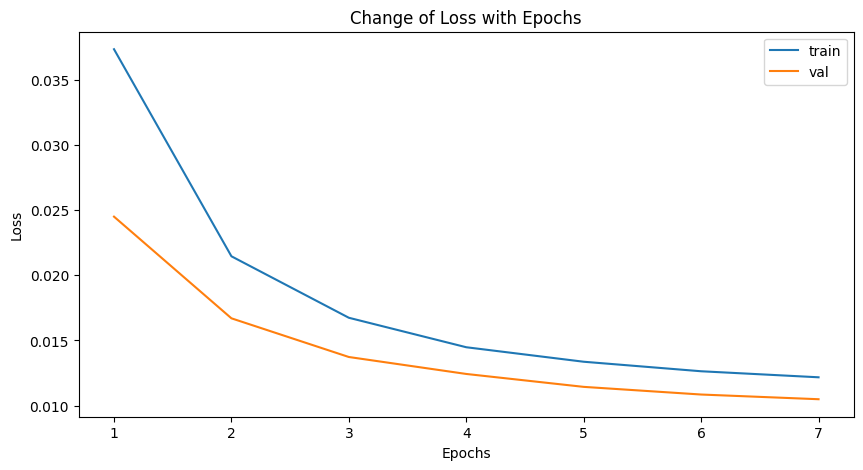

In [126]:
plt.figure(figsize=(10, 5))
x_axis = total_loss_train_list.keys()
y_axis = total_loss_train_list.values()

plt.plot(x_axis, y_axis, label='train')

x_axis = total_loss_val_list.keys()
y_axis = total_loss_val_list.values()

plt.plot(x_axis, y_axis, label='val')

plt.title('Change of Loss with Epochs')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Анализ результатов

Для визуализации точности предсказания модели построим матрицы ошибок

In [133]:
# расчет предсказаний для обучающего датасета
preds_collector = []
topics_id = []

model = model.to(device)
model.eval()

with torch.no_grad():
    for train_input, train_label in train_dataloader:

        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)
        
        output = model(input_id, mask)
        preds = torch.softmax(output[0].to('cpu'), dim=1).detach().numpy()

                
        df_preds = pd.DataFrame(preds, columns=categories)
        preds_collector.append(df_preds)

        topics_id.append(train_label.argmax(dim=1))

df_train_preds = pd.concat(preds_collector)
df_train_preds.reset_index(drop=True, inplace=True)

ar_topics_id = torch.cat(topics_id).numpy()

df_train_preds

,Город,Культура,Наука и техника,Силовые структуры,Спорт,Экономика
0,0.001011,0.958800,0.025223,0.006446,0.007710,0.000810
1,0.985055,0.011112,0.001419,0.000845,0.000041,0.001528
2,0.000027,0.000107,0.000059,0.000074,0.999661,0.000073
3,0.691736,0.035120,0.160379,0.033845,0.003617,0.075303
4,0.001757,0.010354,0.001338,0.007932,0.004113,0.974506
...,...,...,...,...,...,...
7194,0.996487,0.000145,0.000156,0.001138,0.000434,0.001641
7195,0.000167,0.000242,0.000109,0.000220,0.999189,0.000072
7196,0.000885,0.000732,0.000148,0.003914,0.993802,0.000520
7197,0.003060,0.009575,0.028716,0.897495,0.023990,0.037163


In [146]:
dict_idx_cat = {key: item for item, key in list_cat_to_idx}
list_train_true_topics = [dict_idx_cat[x] for x in ar_topics_id]

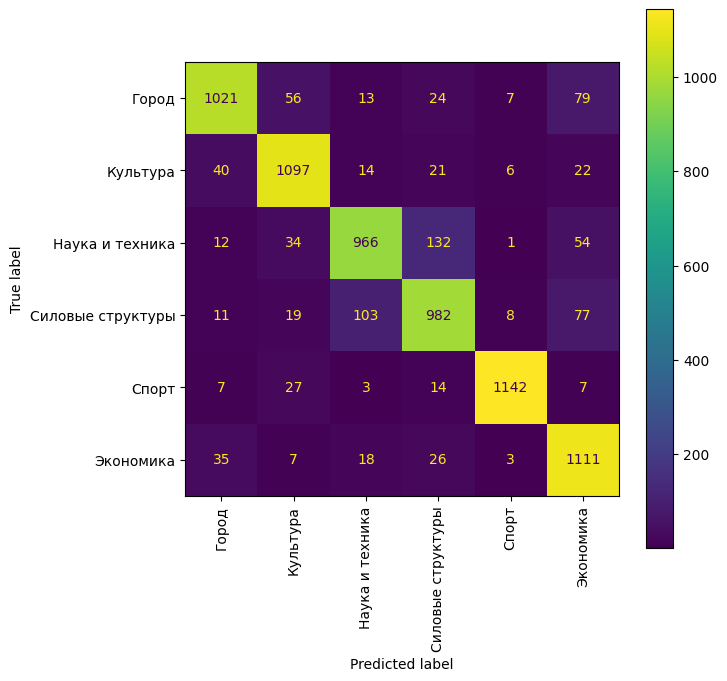

In [149]:
fig, ax = plt.subplots(figsize=(7, 7))
cm = ConfusionMatrixDisplay.from_predictions(
    list_train_true_topics,
    df_train_preds.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

Из представленной матрицы видно, что модель относительно часто путает темы "силовые структуры" и "наука и техника" <br>
и вместо тем "город" и "силовые структуры" предсказывает тему "экономика"

In [150]:
# расчет предсказаний для валидационного датасета

preds_collector = []
topics_id = []

model = model.to(device)
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for val_input, val_label in val_dataloader:

        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)
        
        output = model(input_id, mask)
        preds = torch.softmax(output[0].to('cpu'), dim=1).detach().numpy()

                
        df_preds = pd.DataFrame(preds, columns=categories)
        preds_collector.append(df_preds)

        topics_id.append(train_label.argmax(dim=1))

df_val_preds = pd.concat(preds_collector)
df_val_preds.reset_index(drop=True, inplace=True)

ar_topics_id = torch.cat(topics_id).numpy()

df_val_preds

,Город,Культура,Наука и техника,Силовые структуры,Спорт,Экономика
0,0.005548,0.015013,0.055554,0.065047,0.006518,0.852320
1,0.026009,0.024092,0.767473,0.012362,0.002042,0.168021
2,0.000076,0.000068,0.000038,0.000999,0.998726,0.000093
3,0.004802,0.987120,0.001381,0.001118,0.003117,0.002462
4,0.978689,0.001345,0.001149,0.000493,0.000808,0.017518
...,...,...,...,...,...,...
1762,0.996487,0.000145,0.000156,0.001138,0.000434,0.001641
1763,0.000167,0.000242,0.000109,0.000220,0.999189,0.000072
1764,0.000885,0.000732,0.000148,0.003914,0.993802,0.000520
1765,0.003060,0.009575,0.028716,0.897495,0.023990,0.037163


In [151]:
dict_idx_cat = {key: item for item, key in list_cat_to_idx}
list_val_true_topics = [dict_idx_cat[x] for x in ar_topics_id]

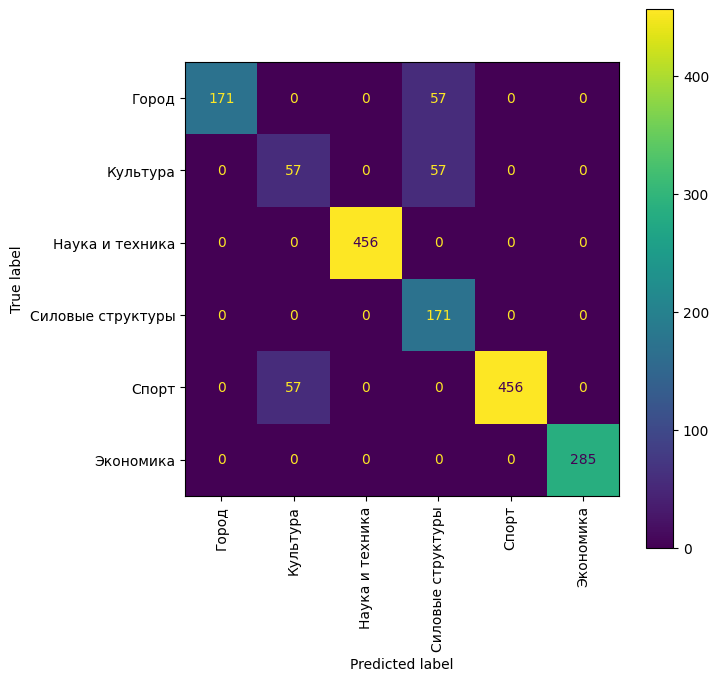

In [152]:
fig, ax = plt.subplots(figsize=(7, 7))
cm = ConfusionMatrixDisplay.from_predictions(
    list_val_true_topics,
    df_val_preds.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

Из представленной матрицы видно, что модель довольно часто вместо тем "город" и "культура" предсказывает тему "силовые структуры" <br>
и вместо темы "спорт" предсказывает "культура". <br>